# Importing Libraries

In [100]:
from     alpha_vantage.foreignexchange import ForeignExchange
from     alpha_vantage.timeseries import TimeSeries
from     collections import Counter
from     matplotlib.pyplot import figure
import   matplotlib.pyplot as plt
import   numpy as np
import   pandas as pd
import   pandas_ta
import   plotly.graph_objs as go
import   plotly.offline as pox
from     sklearn.base import clone 
from     sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from     sklearn.ensemble import VotingClassifier
from     sklearn.linear_model import LogisticRegression
from     sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from     sklearn.model_selection import train_test_split
from     sklearn.naive_bayes import GaussianNB
from     sklearn.neighbors import KNeighborsClassifier
from     sklearn.preprocessing import LabelEncoder, StandardScaler
from     sklearn.svm import SVC
from     sklearn.tree import DecisionTreeClassifier
from     sklearn.utils import resample
import   seaborn as sns
from     statsmodels.tsa.stattools import adfuller
from     statistics import mode
import   talib as ta
from     xgboost import XGBClassifier
import   yfinance as yf

In [101]:
import warnings
warnings.filterwarnings('ignore')

# Importing Stock Data

[*********************100%%**********************]  1 of 1 completed


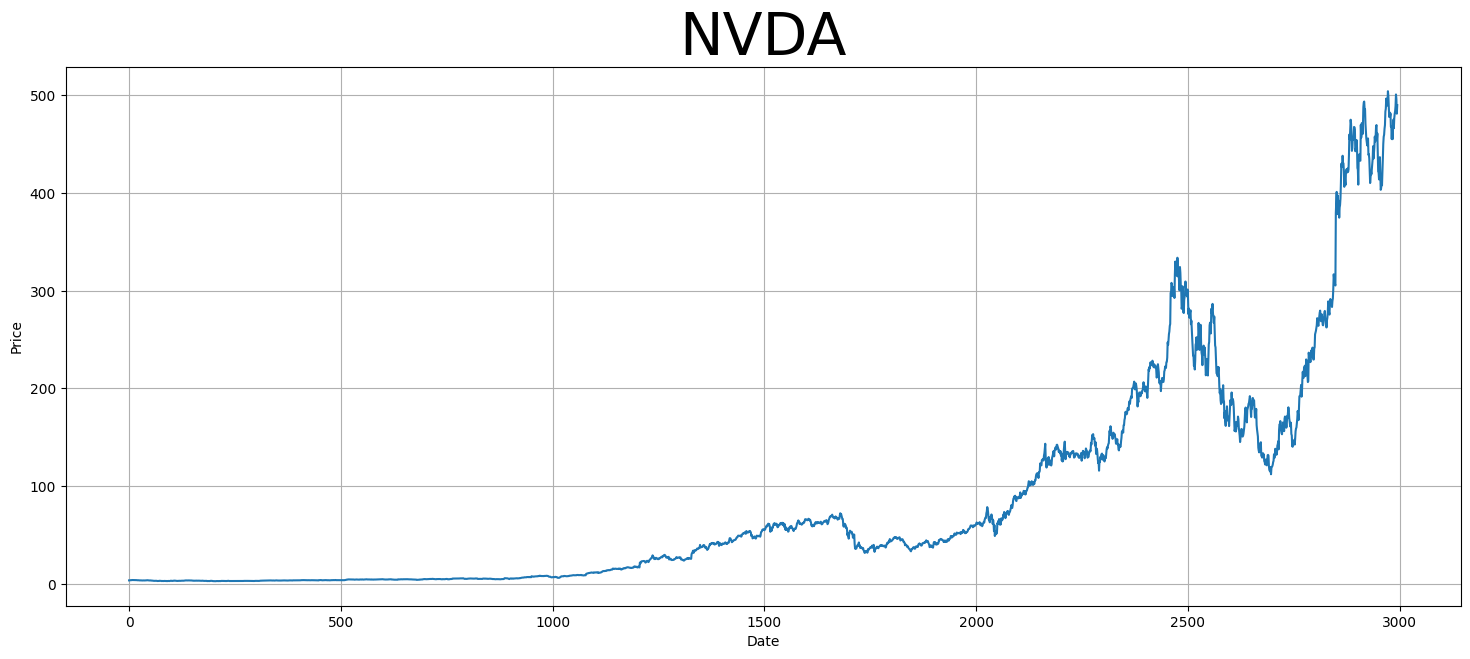

,open,high,low,close,adj close,volume
2990,481.940002,494.040009,481.200012,488.899994,488.877075,47947800
2991,494.000000,504.329987,491.500000,500.769989,500.746490,41258700
2992,494.239990,497.000000,488.950012,496.040009,496.016754,46444400
2993,496.549988,499.989990,480.980011,481.109985,481.087402,39789400
2994,488.109985,490.950012,484.190002,489.899994,489.877014,30042500


In [102]:
# Define the symbol and the date range based on your instruction to limit the analysis to the given range
symb = "NVDA"
start_date = "2012-01-30"
end_date = "2023-12-22"
df = yf.download(symb, start=start_date, end=end_date, interval="1d")

plt.figure(figsize=(18,7))
df.dropna(inplace=True)
df = df.reset_index(drop=True)
plt.plot(df['Close'] )
plt.title(symb,size=42)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()
df.columns = df.columns.str.lower()



next=df.copy()
next.tail()

In [103]:
"""# Your Alpha Vantage API key
api_key = 'BNXP231CB813F1TI'

# Initialize TimeSeries with your key and output format
ts = TimeSeries(key=api_key, output_format='pandas')

# Define your stock symbol and get daily stock data
symb = "GOOGL"

interval_minutes = 1  # Interval between data points
trading_hours_per_day = 6.5  # Typical trading hours in a day
data_points_per_day = int(trading_hours_per_day * 60 / interval_minutes)
# Set the window size for daily volatility
window_size = data_points_per_day

#Intra data
df, meta_data = ts.get_intraday(symbol=symb, interval=interval_minutes, outputsize='full')

#Daily data
#df, meta_data = ts.get_daily(symbol=symb, outputsize='full')

# Process the DataFrame
df.dropna(inplace=True)
df = df.reset_index(drop=True)
plt.figure(figsize=(18,7))
plt.plot(df['4. close'])
plt.title(f'{symb} Stock Close Price', size=42)
plt.grid()
plt.show()


# Rename columns to a more familiar format
df.rename(columns={
    '1. open': 'open', 
    '2. high': 'high', 
    '3. low': 'low', 
    '4. close': 'close', 
    '5. volume': 'volume',
}, inplace=True)




next=df.copy()
next.tail()"""

'# Your Alpha Vantage API key\napi_key = \'BNXP231CB813F1TI\'\n\n# Initialize TimeSeries with your key and output format\nts = TimeSeries(key=api_key, output_format=\'pandas\')\n\n# Define your stock symbol and get daily stock data\nsymb = "GOOGL"\n\ninterval_minutes = 1  # Interval between data points\ntrading_hours_per_day = 6.5  # Typical trading hours in a day\ndata_points_per_day = int(trading_hours_per_day * 60 / interval_minutes)\n# Set the window size for daily volatility\nwindow_size = data_points_per_day\n\n#Intra data\ndf, meta_data = ts.get_intraday(symbol=symb, interval=interval_minutes, outputsize=\'full\')\n\n#Daily data\n#df, meta_data = ts.get_daily(symbol=symb, outputsize=\'full\')\n\n# Process the DataFrame\ndf.dropna(inplace=True)\ndf = df.reset_index(drop=True)\nplt.figure(figsize=(18,7))\nplt.plot(df[\'4. close\'])\nplt.title(f\'{symb} Stock Close Price\', size=42)\nplt.grid()\nplt.show()\n\n\n# Rename columns to a more familiar format\ndf.rename(columns={\n    \'

In [104]:
tfig = go.Figure()
tfig.add_trace(go.Candlestick(
    x=df.index, 
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='market data'
))

tfig.update_layout(
    title=f'{symb} live share price evolution',
    yaxis_title='Stock Price (in $)'
)

tfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label='15m', step='minute', stepmode='backward'),
            dict(count=45, label='45m', step='minute', stepmode='backward'),
            dict(count=1, label='HTD', step='hour', stepmode='todate'),
            dict(count=2, label='2h', step='hour', stepmode='backward'),
            dict(step='all')
        ])
    )
)

tfig.show()


# Feature Engineering

In [105]:
df['future_returns'] = df['close'].pct_change().shift(-1)
signal=[]
for i in range(len(df)):
    if (df['future_returns'][i]  > 0):
        signal.append(1)
    elif (df['future_returns'][i] < 0):
        signal.append(2)
    else:
        signal.append(3)


df['signal']=signal
df['rsi'] = ta.RSI(df['close'].values, timeperiod=int(14))
df['adx'] = ta.ADX(df['high'].values, df['low'].values,df['open'].values, timeperiod=int(50))
df['NATR'] = ta.NATR(df['high'], df['low'], df["close"], timeperiod=50)
df['pct_change_5'] = df['close'].pct_change(5)
df['pct_change'] = df['close'].pct_change()
df['sma'] = ta.SMA(df['close'],timeperiod=30)
df['corr'] = df['close'].rolling(window=int(6.5*4)).corr(df['sma'])
df['Open-Close']=(df["open"]-df['close']).shift(-1)
df['Close-High']=(df["close"]-df['high']).shift(-1)
df['Close-Low']=(df["close"]-df['low']).shift(-1)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['close'], timeperiod=20)


## Calculate the log high/low and log close/open
#log_hl = np.log(df['high'] / df['low']) ** 2
#log_co = np.log(df['close'] / df['open']) ** 2
#
##Adding some Additional Feature engineeering techniques
## Rolling Windows
#df['rolling_mean'] = df['close'].rolling(window=20).mean()
#df['rolling_std'] = df['close'].rolling(window=20).std()
#df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()
#
## Statistical Features
#df['rate_of_change'] = df['close'].pct_change().fillna(0)
#df['z_score'] = (df['close'] - df['rolling_mean']) / df['rolling_std']
#
## Feature Interaction
#df['close_volume_interaction'] = df['close'] * df['volume']


## Technical Indicators
#df['momentum'] = df['close'] - df['close'].shift(4)
#df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowd_period=3)

df

,open,high,low,close,adj close,volume,future_returns,signal,rsi,adx,...,corr,Open-Close,Close-High,Close-Low,macd,macdsignal,macdhist,upper_band,middle_band,lower_band
0,3.662500,3.717500,3.607500,3.700000,3.394018,39907600,-0.002027,2,NaN,NaN,...,NaN,0.017500,-0.020000,0.065000,NaN,NaN,NaN,NaN,NaN,NaN
1,3.710000,3.712500,3.627500,3.692500,3.387139,35790000,0.010833,1,NaN,NaN,...,NaN,0.002500,-0.042500,0.050000,NaN,NaN,NaN,NaN,NaN,NaN
2,3.735000,3.775000,3.682500,3.732500,3.423831,42802000,0.037508,1,NaN,NaN,...,NaN,-0.120000,-0.015000,0.157500,NaN,NaN,NaN,NaN,NaN,NaN
3,3.752500,3.887500,3.715000,3.872500,3.552252,69623600,0.021304,1,NaN,NaN,...,NaN,-0.025000,-0.032500,0.032500,NaN,NaN,NaN,NaN,NaN,NaN
4,3.930000,3.987500,3.922500,3.955000,3.627930,49523200,-0.007585,2,NaN,NaN,...,NaN,0.010000,-0.015000,0.035000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,481.940002,494.040009,481.200012,488.899994,488.877075,47947800,0.024279,1,58.756538,13.887870,...,-0.346334,-6.769989,-3.559998,9.269989,4.474919,4.055263,0.419656,503.450377,477.587001,451.723625
2991,494.000000,504.329987,491.500000,500.769989,500.746490,41258700,-0.009445,2,63.156322,13.890647,...,-0.262720,-1.800018,-0.959991,7.089996,6.093908,4.462992,1.630916,504.965546,477.976500,450.987454
2992,494.239990,497.000000,488.950012,496.040009,496.016754,46444400,-0.030098,2,60.391632,13.876759,...,-0.158943,15.440002,-18.880005,0.129974,6.915581,4.953509,1.962071,503.198905,477.574001,451.949096
2993,496.549988,499.989990,480.980011,481.109985,481.087402,39789400,0.018270,1,52.569120,13.811759,...,-0.134627,-1.790009,-1.050018,5.709991,6.289532,5.220714,1.068818,500.325032,476.657500,452.989968


In [106]:

df.dropna(inplace=True)

y = df[['signal']].copy()
print(y)
exclude_columns = ['date', 'signal','NATR','adj close','close','future_returns','high','low','macdhist', 
                   'macdsignal','open','pct_change_5','pct_change','sma']  # Add any other columns you want to exclude from X
X = df[df.columns.difference(exclude_columns)]
print(X)

      signal
99         2
100        1
101        2
102        1
103        1
...      ...
2989       1
2990       1
2991       2
2992       2
2993       1

[2895 rows x 1 columns]
      Close-High  Close-Low  Open-Close        adx      corr  lower_band  \
99     -0.150000   0.007500    0.150000  16.985804  0.142455    2.887126   
100    -0.037500   0.045000    0.000000  16.698290 -0.026243    2.885593   
101    -0.115000   0.012500    0.105000  16.416527 -0.156934    2.888784   
102    -0.022500   0.062500   -0.017500  16.192462 -0.253367    2.890448   
103    -0.022500   0.100000   -0.100000  15.983894 -0.226709    2.890407   
...          ...        ...         ...        ...       ...         ...   
2989   -5.140015   7.699982   -6.959991  13.937461 -0.337969  451.382439   
2990   -3.559998   9.269989   -6.769989  13.887870 -0.346334  451.723625   
2991   -0.959991   7.089996   -1.800018  13.890647 -0.262720  450.987454   
2992  -18.880005   0.129974   15.440002  13.876759 -0.15894

# Correlation Check

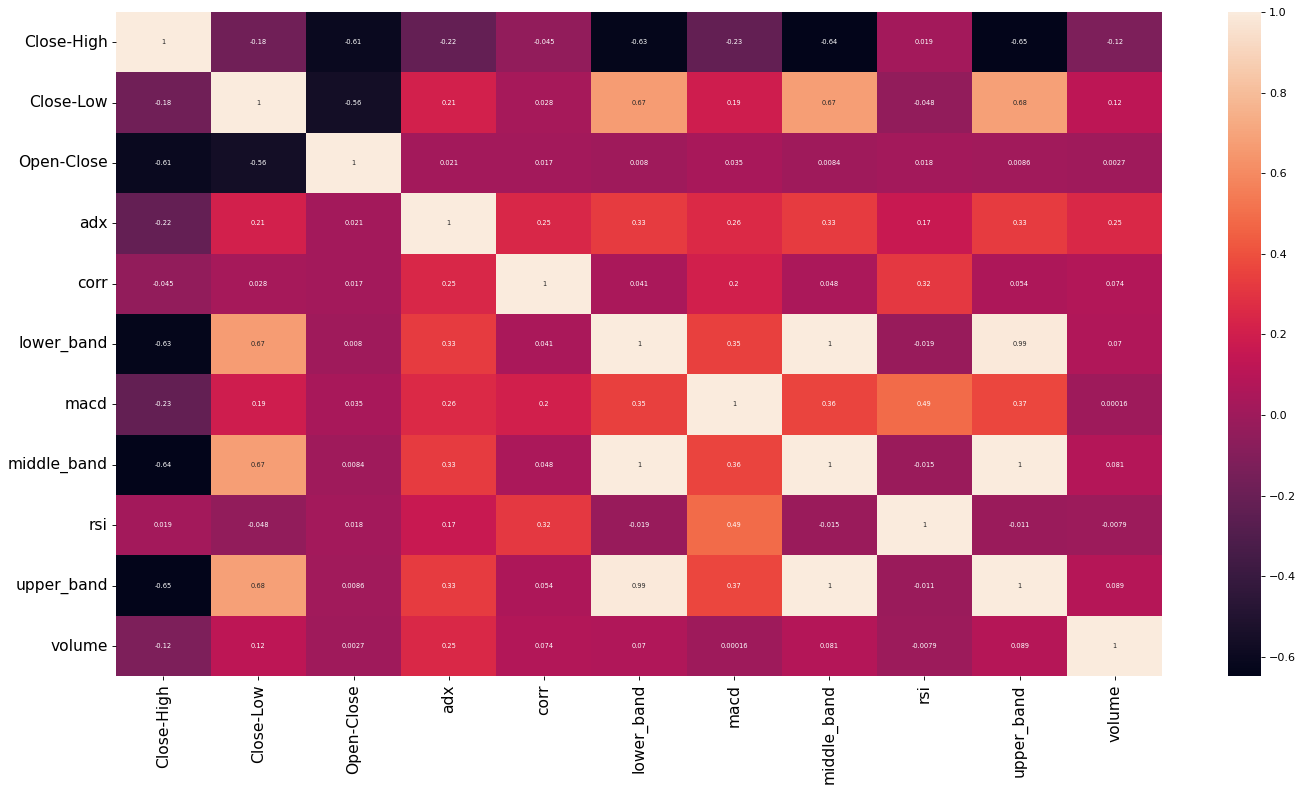

In [107]:
exclude_columns = ['date', 'signal','NATR','adj close','close','future_returns','high','low','macdhist', 
                   'macdsignal','open','pct_change_5','pct_change','sma'] 
z=df[df.columns.difference(exclude_columns)].copy()
corr = z.corr()
figure(figsize=(18, 10), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14); 
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [108]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
   
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))


MultiIndex([('middle_band',  'upper_band'),
            ( 'lower_band', 'middle_band'),
            ( 'lower_band',  'upper_band')],
           )


# Stationary Check

In [109]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    status = stationary(df[col])
    if status == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Close-High is not stationary. Dropping it.
Close-Low is not stationary. Dropping it.
Open-Close is stationary.
adx is stationary.
corr is stationary.
lower_band is not stationary. Dropping it.
macd is stationary.
middle_band is not stationary. Dropping it.
rsi is stationary.
upper_band is not stationary. Dropping it.
volume is stationary.


# Splitting and Training Model

In [110]:
split_percentage = 0.8
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [111]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2316, 6)
(2316, 1)
(579, 6)
(579, 1)


In [112]:
# use transform instead of fit_transform for testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [113]:


# Define each model with the specified parameters
#model = SVC(C=1, kernel='rbf', degree=3, probability=True)
#model1 = LogisticRegression(max_iter=1000)  # Assuming '1bfgs' was a typo and should be 'lbfgs'
#model3 = DecisionTreeClassifier(criterion='gini', random_state=20, min_samples_split=2)  # Random state and min_samples_split set based on one of the provided values
#model5 = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=30, min_samples_leaf=4, min_samples_split=2)
#model= AdaBoostClassifier(n_estimators=100, algorithm='SAMME.R', learning_rate=1, estimator=model3)
#model = KNeighborsClassifier(n_neighbors=5)

#model = VotingClassifier([('lr', model1), ('ds', model2), ('svm', model3),('ada', model4)], voting='soft')

encoder = LabelEncoder()
y_train['signal'] = encoder.fit_transform(y_train['signal'])
y_test = encoder.transform(y_test)
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='mlogloss')

print(model)

model.fit(X_train, y_train['signal'])
y_pred = model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

y_prob = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc:.4f}")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Accuracy: 0.8290
F1-Score: 0.8282
ROC-AUC: 0.6243


# Confusion Matrix

In [114]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       303
           1       0.83      0.81      0.82       275
           2       0.00      0.00      0.00         1

    accuracy                           0.83       579
   macro avg       0.55      0.55      0.55       579
weighted avg       0.83      0.83      0.83       579



# Bootstrapping

In [115]:
# Bootstrapping function for training multiple Moodels
def bootstrap_training(X_train, y_train, model, n_bootstrap=100):
    models = []
    for _ in range(n_bootstrap):
        # Resampling with replacement
        X_resampled, y_resampled = resample(X_train, y_train)
        # Clone the model to ensure each bootstrap sample gets a fresh model
        cloned_model = clone(model)
        cloned_model.fit(X_resampled, y_resampled)
        models.append(cloned_model)
    return models

In [116]:
# Function to predict with an ensemble of models
def predict_with_ensemble(models, X):
    # Get predictions from all models (for majority voting, we're interested in the class labels, not probabilities)
    all_predictions = np.array([model.predict(X) for model in models])
    # Aggregate predictions by majority voting
    aggregated_predictions = np.apply_along_axis(lambda x: mode(x), arr=all_predictions, axis=0)
    return aggregated_predictions

In [117]:
# Implement bootstrapping in the existing workflow using the model choosen above
ensemble_models = bootstrap_training(X_train, y_train, model, n_bootstrap=100)

# Modify the prediction mechanism to use the ensemble
y_pred = predict_with_ensemble(ensemble_models, X_test)


# calculate Performance
Accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

y_prob = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8325
F1-Score: 0.8317
ROC-AUC: 0.6243


# Confusion Matrix

In [118]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       303
           1       0.83      0.82      0.82       275
           2       0.00      0.00      0.00         1

    accuracy                           0.83       579
   macro avg       0.55      0.56      0.56       579
weighted avg       0.83      0.83      0.83       579



# Making Latest Prediciton

In [119]:
Prediction=model.predict(X.values)[-1]
if Prediction==1:
    print('Buy')
elif Prediction==2:
    print('Sell')
else:
    print('Hold')
print(Prediction)

Hold
0


In [120]:
split_percentage = 0.8
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
temp.tail()

,close,signal
2989,483.500000,0
2990,488.899994,0
2991,500.769989,0
2992,496.040009,1
2993,481.109985,0


In [121]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4

# Decision Making Process

In [122]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'].iloc[i]== 1 :                          #Buy Position
                    buy.append(temp['close'].iloc[i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'].iloc[i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'].iloc[i]== 2   :                     #Sell Position        
                sell.append(temp['close'].iloc[i])              
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'].iloc[i])
                position_Sell="Sell"
        
    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'].iloc[i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'].iloc[i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'].iloc[i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'].iloc[i]):                  #Take Profit Condition
            Close_profit.append(temp['close'].iloc[i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None
           
        elif ((Close_order_buy[-1]-lose) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'].iloc[i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            df['future_returns'] = df['close'].pct_change().shift(-1)
            position_Buy=None
     
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")

close           579
signal          579
buy             185
sell              0
Close_profit     34
Stop_loss       151
dtype: int64
Profitibily 0.1837837837837838


# Plotting

In [123]:

trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(
   
    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(
    
    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(
    
    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(
    
    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title=symb,
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Time And date'))


figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)

'temp-plot.html'